In [1]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from tensorflow.keras.callbacks import EarlyStopping

Читаем данные из файла со значениями цены нефти марки BRENT

In [3]:
files.upload()
!ls

Saving my_BRENT2019.csv to my_BRENT2019.csv
my_BRENT2019.csv  sample_data


In [4]:
df = pd.read_csv('my_BRENT2019.csv')


In [5]:
df.head()

,Дата,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
0,2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
1,2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2,2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
3,2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
4,2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Отбросим первый столбец, т.к. признаки [year,	month,	dayofmonth,	quarter,	dayofyear,	weekofyear,	dayofweek,	is_holiday,	is_prev_holiday,	is_next_holiday] его представляют

In [6]:
data = df.iloc[1500:,1:]  # убираем данные до 2015 года , т.к. сильно изменилось поведение и дату-время, т.к. она дублирована другими признаками

In [7]:
data.shape[1]

11

Делаем нормализацию

In [8]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

Можно (и нужно заменять на sklearn StandadScaler) т.к. это нужно дополнительно сохранять для обработки реальных данных , но тут сделаем без привлечения внешних модулей

In [9]:
train_split = 1000
data_v =  normalize(data.values, train_split)
data_f = pd.DataFrame(data_v)

Создаем данные для обучения

In [54]:
# список признаков, по которым будем учить
channelIndexes = [0,1, 2, 4, 5, 6, 7]

# длина теста
valLen = 100
# длина истории для работы
xLen = 3
# отступ тестов от тренировок
bias = 10

# вычисляем точку разделения ряда на тесты и тренировку
#train_split = data_f.shape[0] - valLen - bias
# делим
train_data = data_f.iloc[0 : train_split - 1,channelIndexes]
val_data = data_f.iloc[train_split+bias:,channelIndexes]



In [55]:
train_data.head(7)

,0,1,2,4,5,6,7
0,-0.565289,-1.903377,0.651736,0.383476,0.543890,0.566107,0.853697
1,-0.643628,-1.903377,0.651736,0.383476,0.571352,0.630008,-1.338080
2,-0.751345,-1.903377,0.651736,0.383476,0.580506,0.630008,-0.790136
3,-0.588954,-1.903377,0.651736,0.383476,0.589660,0.630008,-0.242191
4,-0.810099,-1.903377,0.651736,0.383476,0.598814,0.630008,0.305753
5,-0.591402,-1.903377,0.651736,0.383476,0.607968,0.630008,0.853697
6,-0.671373,-1.903377,0.651736,0.383476,0.635431,0.693910,-1.338080


Формируем параметры для генерации выборки

In [57]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 10


Выделяем части на обучение и проверку

In [58]:
start = xLen + future
end = start + train_split-1

xTrain = train_data[[train_data.columns[i] for i in range(7)]].values
yTrain = data_f.iloc[start:end,0].values

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future

label_start = len(train_data)+bias+xLen + future

xVal = val_data.iloc[:x_end+1][[val_data.columns[i] for i in range(7)]].values
yVal = data_f.iloc[label_start:,0].values


In [59]:
print(xTrain.shape)

print(yTrain.shape)


print(xVal.shape)

print(yVal.shape)

(999, 7)
(999,)
(154, 7)
(154,)


Посмотрим на них

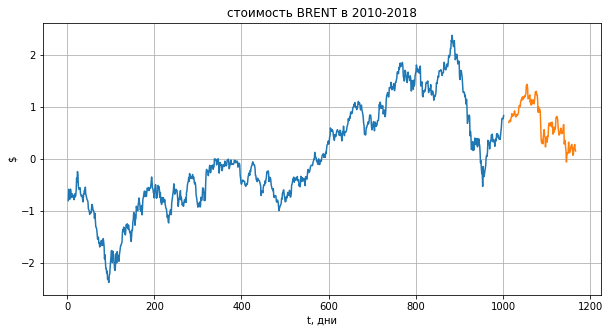

In [60]:
plt.figure(figsize=(10,5))
plt.plot(data_f.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data_f.index[yTrain.shape[0]+xLen+bias+future:],yVal[:])
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
plt.title('стоимость BRENT в 2010-2018')
plt.show()

Используем механизм формирования пакетов для обучения

In [61]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)


In [62]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 3, 7)
Target shape: (32,)


In [63]:
inputs[2,:,0]

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-0.72931193, -0.70891105, -0.7284959 ])>

In [64]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=-0.7284958959430199>

**сеть:  LSTM слои+Conv1D +Dense слой.**

Epoch 1/10
32/32 [==============================] - 1s 28ms/step - loss: 0.9552 - mae: 0.7849 - val_loss: 0.2364 - val_mae: 0.4066
Epoch 2/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1714 - mae: 0.2915 - val_loss: 0.5347 - val_mae: 0.7037
Epoch 3/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1230 - mae: 0.2894 - val_loss: 0.2736 - val_mae: 0.4930
Epoch 4/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1019 - mae: 0.2488 - val_loss: 0.0930 - val_mae: 0.2536
Epoch 5/10
32/32 [==============================] - 0s 13ms/step - loss: 0.1526 - mae: 0.3074 - val_loss: 0.2246 - val_mae: 0.4405
Epoch 6/10
32/32 [==============================] - 0s 12ms/step - loss: 0.0617 - mae: 0.2025 - val_loss: 0.0617 - val_mae: 0.1973
Epoch 7/10
32/32 [==============================] - 0s 10ms/step - loss: 0.0834 - mae: 0.2336 - val_loss: 0.2341 - val_mae: 0.4571
Epoch 8/10
32/32 [==============================] - 0s 11ms/step - loss: 0.0434 - m

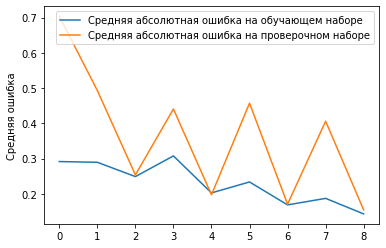

In [94]:
callback = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(32, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(32, return_sequences="True"))
model.add(Conv1D(64, 3, activation="linear"))
#model.add(Conv1D(64, 1, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [95]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

Epoch 1/10
32/32 [==============================] - 0s 10ms/step - loss: 0.0383 - mae: 0.1579 - val_loss: 0.1308 - val_mae: 0.3296
Epoch 2/10
32/32 [==============================] - 0s 11ms/step - loss: 0.0265 - mae: 0.1275 - val_loss: 0.0408 - val_mae: 0.1524
Epoch 3/10
32/32 [==============================] - 0s 10ms/step - loss: 0.0301 - mae: 0.1382 - val_loss: 0.0885 - val_mae: 0.2599
Epoch 4/10
32/32 [==============================] - 0s 10ms/step - loss: 0.0244 - mae: 0.1225 - val_loss: 0.0425 - val_mae: 0.1572
Epoch 5/10
32/32 [==============================] - 0s 10ms/step - loss: 0.0260 - mae: 0.1274 - val_loss: 0.0642 - val_mae: 0.2112
Epoch 6/10
32/32 [==============================] - 0s 10ms/step - loss: 0.0238 - mae: 0.1213 - val_loss: 0.0414 - val_mae: 0.1555
Epoch 7/10
32/32 [==============================] - 0s 10ms/step - loss: 0.0243 - mae: 0.1227 - val_loss: 0.0511 - val_mae: 0.1816


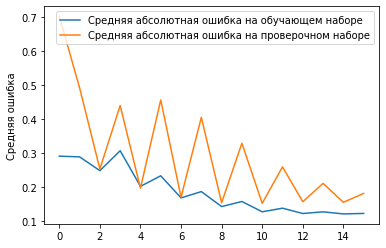

In [96]:

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callback])

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

plt.plot(hist_train[1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [97]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

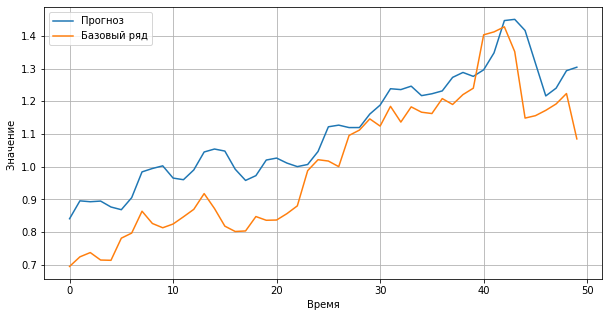

In [98]:
start = 0
step = 50
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[h+start:h+start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

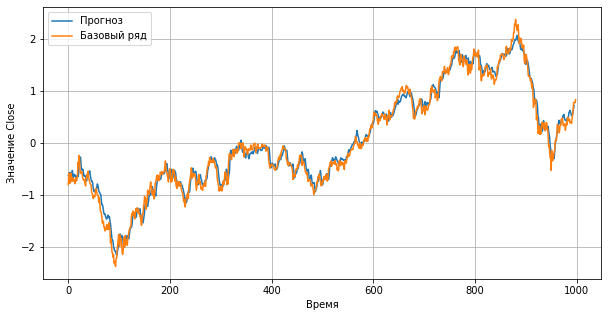

In [99]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[h+start:h+train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Проверяем качество модели

In [100]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

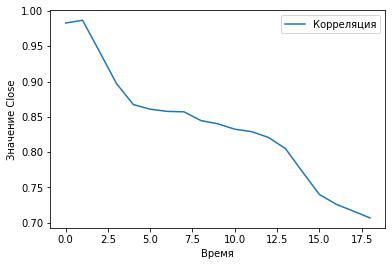

In [101]:
corr = []
start = 0
step = 50
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten()
yPredVal = predVal[h+start:start+step+h]
for i in range(1,20):
  corr.append(correlate(yValF[:-i], yPredVal[i:]))
  
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

In [102]:
corr

[0.9828644933252331,
 0.9868174234469993,
 0.9423891587853068,
 0.8973095971543429,
 0.8673340976819337,
 0.8607605290594865,
 0.8576999820538239,
 0.8570509233341876,
 0.8446765669338733,
 0.8400371043549801,
 0.8324413750434922,
 0.8289493180564543,
 0.8207210966862436,
 0.8048880293203216,
 0.7721623017019507,
 0.74006575070079,
 0.7260483622123157,
 0.7164868262996299,
 0.7067367419219448]

есть запаздывание